In [1]:
#Written by Trym Haugan Berger (Kaggle username: Lavie86) HVL studID: 598115

import numpy as np 
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neural_network import MLPClassifier

In [2]:
#Define custom functions:
def plot_histogram(data):
    for feature in data:
        plt.figure(figsize=(8, 4))
        plt.hist(data[feature].dropna(), bins=15, edgecolor='k')
        plt.title(f'Histogram of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.show()
        
#Data transformation pipeline
class CustomLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = np.log(X)
        return X

class CustomOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.005, upper_quantile=0.995):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        self.lower_bound = X.quantile(self.lower_quantile)
        self.upper_bound = X.quantile(self.upper_quantile)
        return self

    def transform(self, X, y=None):
        return X.clip(lower=self.lower_bound, upper=self.upper_bound, axis=1)
    
# Pipeline for BMI
bmi_pipeline = Pipeline(steps=[
    ('clip_outliers', CustomOutlierClipper()),
    ('log_transform', CustomLogTransformer()),
    ('scaler', MinMaxScaler()) 
])

#pipeline for MentHlth, physhlth, education
binary_bucketizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
binary_pipeline = Pipeline(steps=[
    ('bucketize', binary_bucketizer),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('bmi', bmi_pipeline, ['BMI']),
        ('bucketize_menthlth', binary_pipeline, ["PhysHlth"]),
        ('bucketize_PhysHlth', binary_pipeline, ["MentHlth"]),
        ('bucketize_education', binary_pipeline, ["Education"]),
        ('scale', MinMaxScaler(), ["GenHlth", "Age", "Income"]) 
    ],
    remainder='passthrough'
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [3]:
#Import dataset

train_data = pd.read_csv("/kaggle/input/diab-training-set/train.csv")
test_data = pd.read_csv("/kaggle/input/diab-test-set/test.csv")
train_data.head(5)

,Id,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Target
0,1,1,1,1,21,0,0,0,1,1,...,0,4,0,0,0,0,13,4,5,1
1,2,1,0,1,26,1,0,0,1,1,...,0,3,0,0,0,0,10,5,3,0
2,3,1,1,1,29,0,0,1,0,0,...,0,3,15,5,0,1,13,6,8,1
3,4,1,1,1,27,0,0,0,1,1,...,0,2,0,0,0,1,9,6,8,0
4,5,1,1,1,26,1,0,0,0,0,...,0,2,0,0,0,0,6,5,7,0


In [4]:
#Preparing data for processing
data = train_data.copy()
data = data.drop(["Id"], axis=1)

y = train_data["Target"]
data = data.drop(["Target"], axis=1)
X = data

In [5]:
transformed_columns = [
    'BMI',               # From 'bmi_pipeline'
    'MentHlth',          # From 'bucketize_menthlth'
    'PhysHlth',          # From 'bucketize_physhlth'
    'Education',         # From 'bucketize_education'
    'GenHlth', 'Age', 'Income',  # From 'scale'
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]

final_pipeline.fit(X)
X_transformed = final_pipeline.transform(X)

X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_columns)

original_order = X.columns.tolist()
X_transformed_df = X_transformed_df[original_order]

X_transformed_df.head(5)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,0.179972,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.75,0.0,0.0,0.0,0.0,1.000000,1.0,0.571429
1,1.0,0.0,1.0,0.361874,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.750000,1.0,0.285714
2,1.0,1.0,1.0,0.454879,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.50,0.0,1.0,0.0,1.0,1.000000,1.0,1.000000
3,1.0,1.0,1.0,0.394017,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.0,0.0,0.0,1.0,0.666667,1.0,1.000000
4,1.0,1.0,1.0,0.361874,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.416667,1.0,0.857143


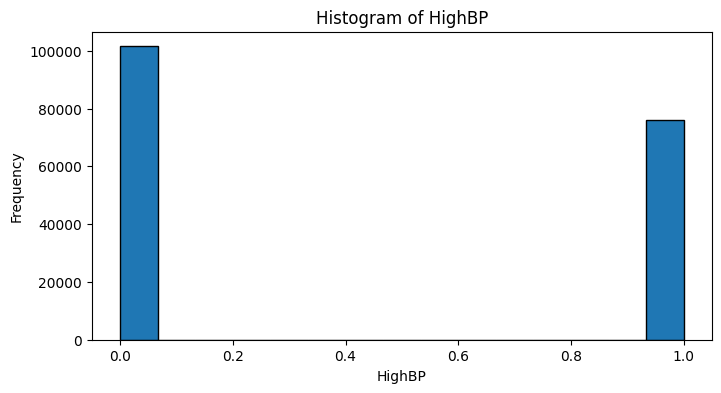

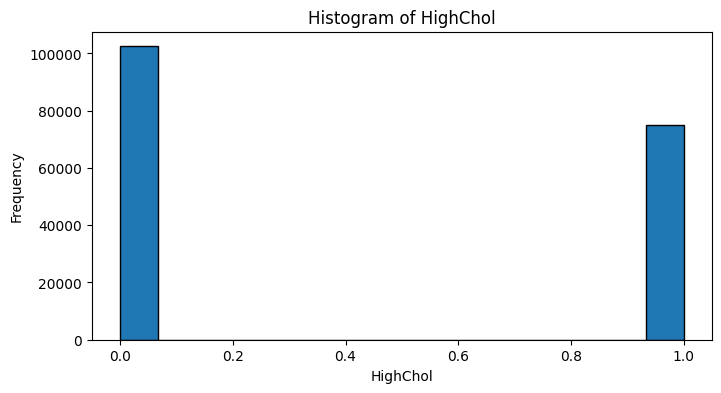

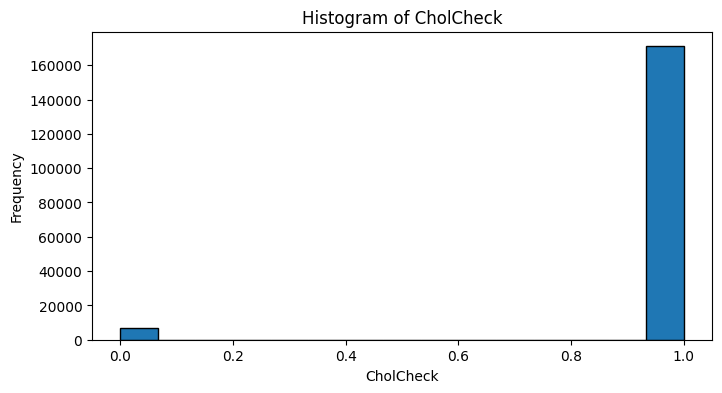

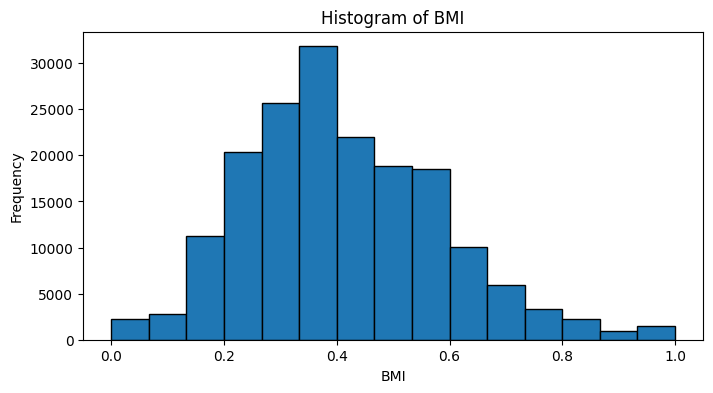

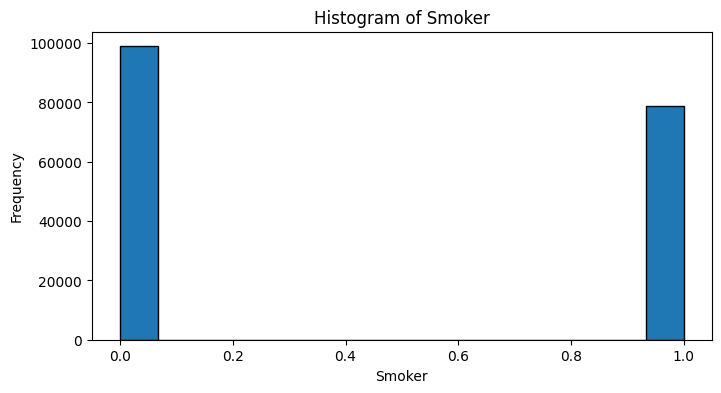

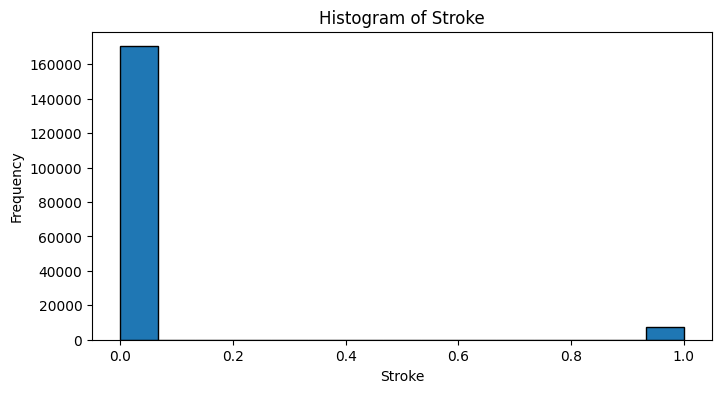

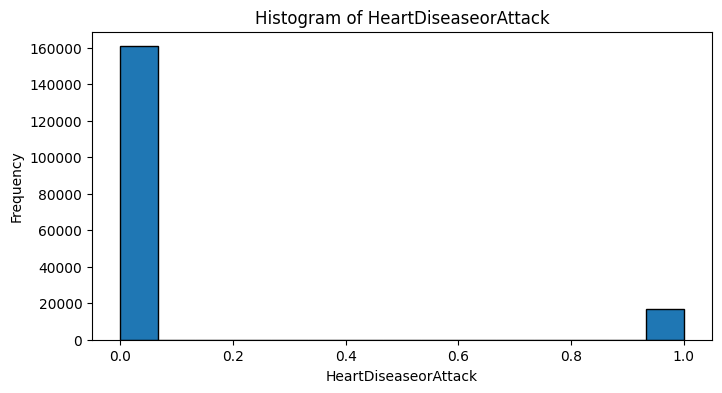

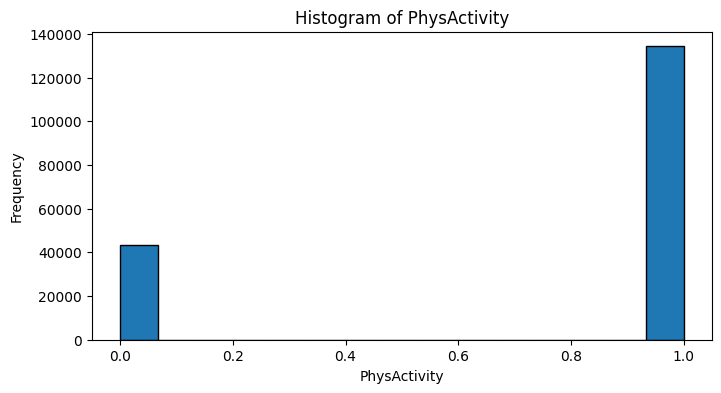

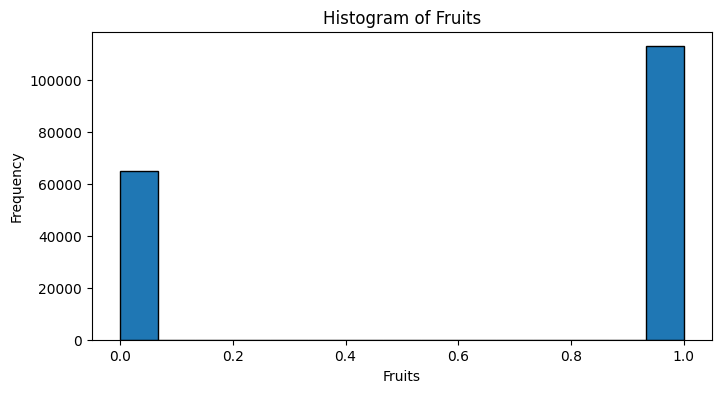

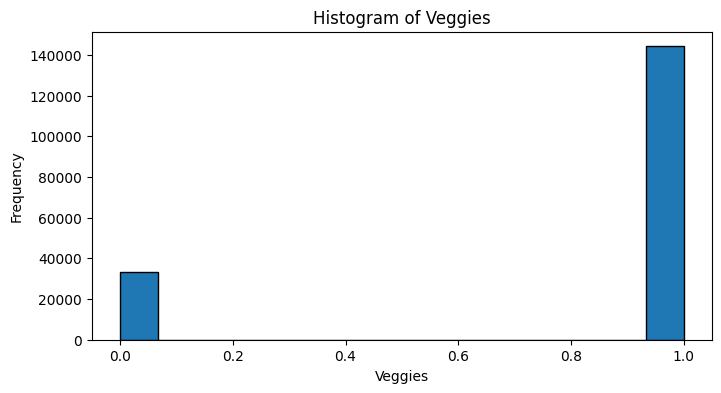

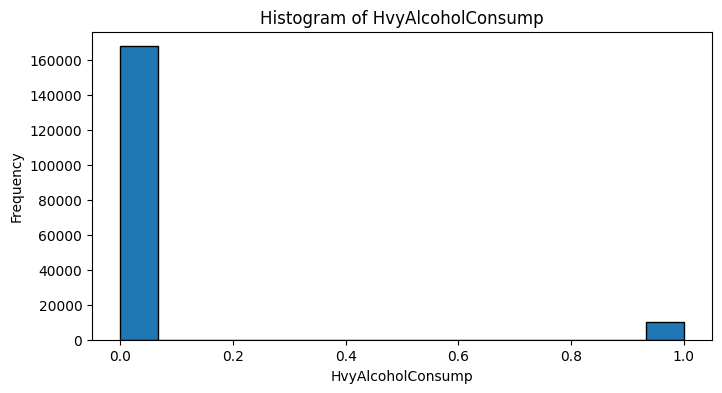

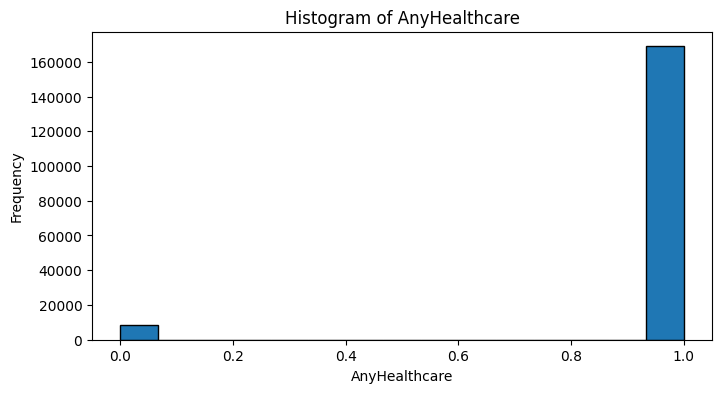

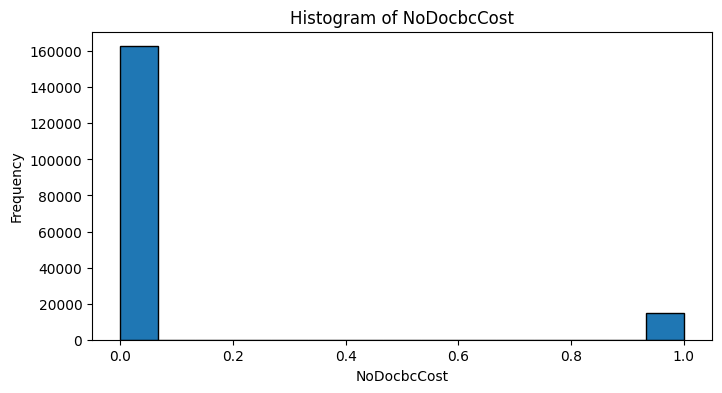

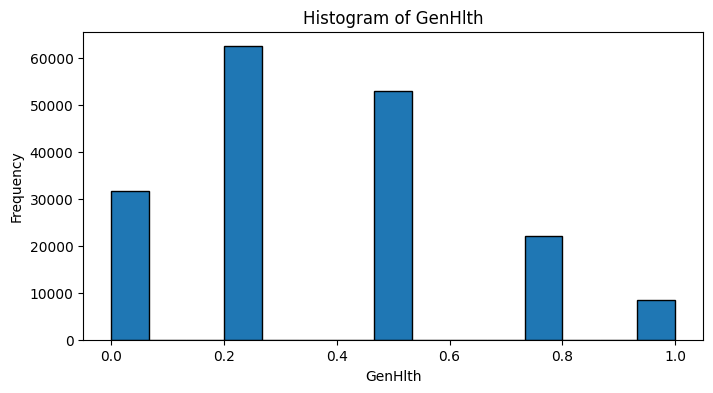

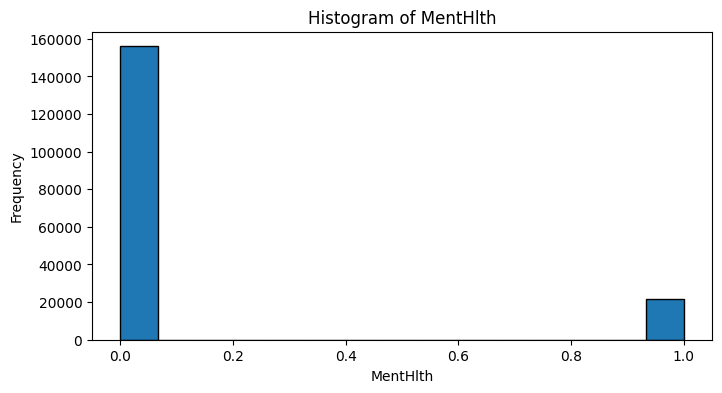

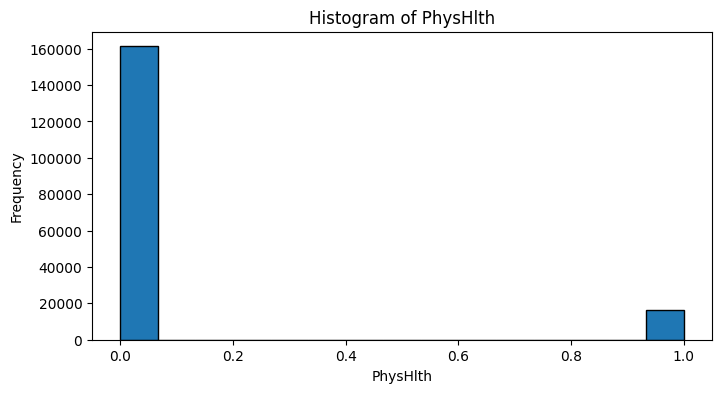

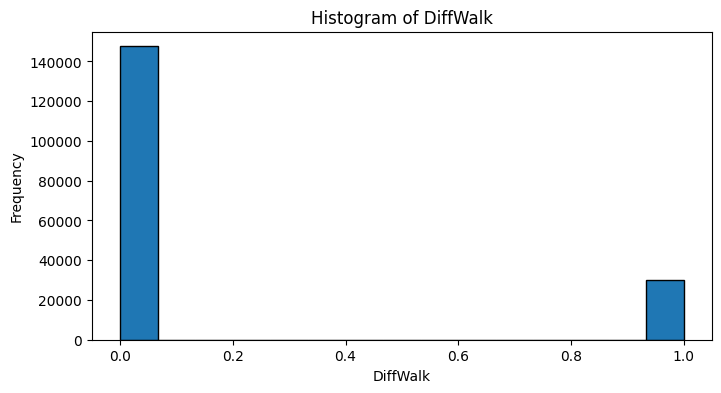

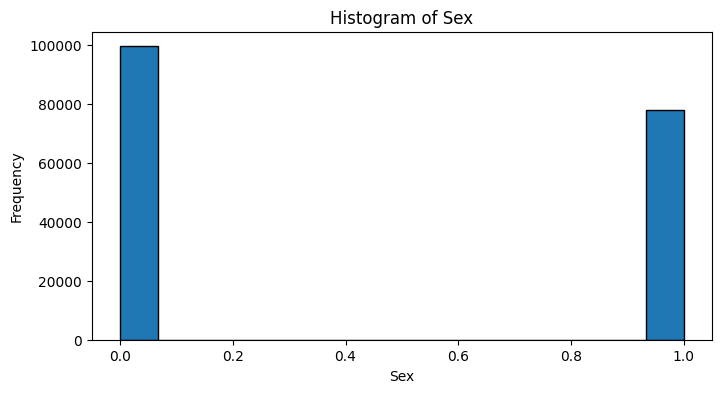

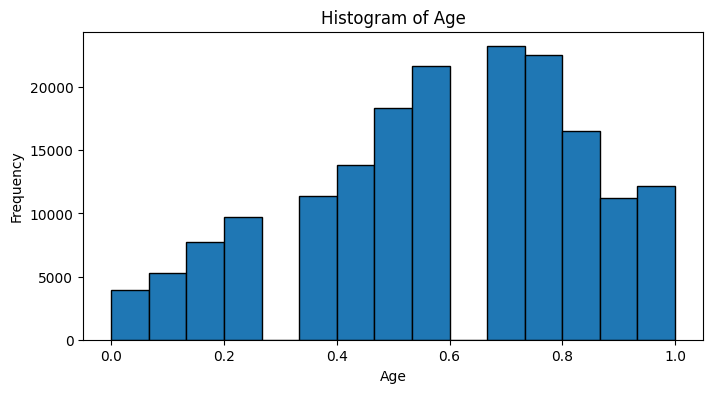

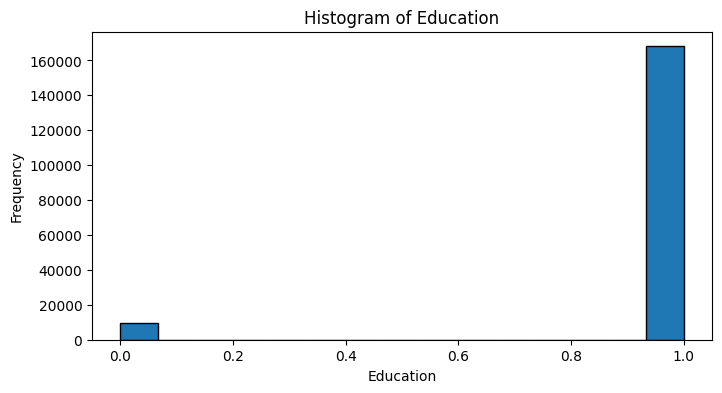

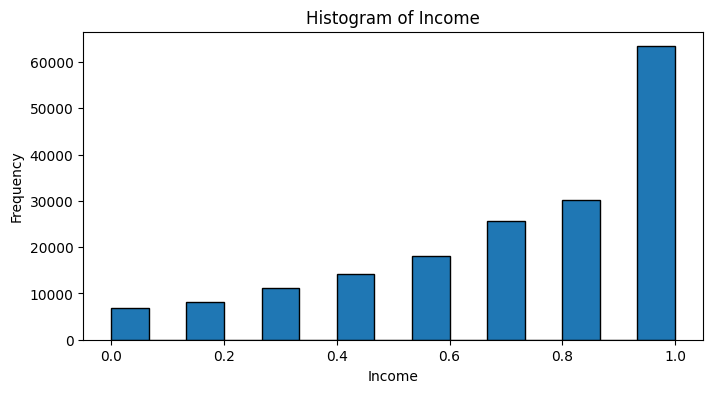

In [6]:
plot_histogram(X_transformed_df)

In [7]:
X = X_transformed_df

#Initialize model
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=42)
    
#Train
mlp.fit(X, y)

MLPClassifier(max_iter=300, random_state=42)

In [8]:
#Prepare test set
ids = test_data['Id']
test_data = test_data.drop("Id", axis=1)
test_data.head(5)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,0,1,33,0,0,0,1,0,1,...,1,0,3,0,0,0,1,5,4,8
1,0,0,1,20,1,0,0,1,1,1,...,0,1,3,2,15,0,1,7,6,4
2,0,0,1,23,1,0,0,1,0,1,...,1,0,2,0,4,0,0,3,6,8
3,1,0,1,43,0,0,0,1,1,1,...,1,0,3,1,0,0,0,8,6,7
4,0,0,1,24,1,0,0,1,1,1,...,1,0,1,0,0,0,0,7,6,8


In [9]:
Xt = test_data

final_pipeline.fit(Xt)
test_set_scaled_list = final_pipeline.transform(Xt)

test_set_scaled = pd.DataFrame(test_set_scaled_list, columns=transformed_columns)

original_order = Xt.columns.tolist()
test_set_scaled = test_set_scaled[original_order]
test_set_scaled.head(10)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,0.0,1.0,0.564929,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.50,0.0,0.0,0.0,1.0,0.333333,1.0,1.000000
1,0.0,0.0,1.0,0.138418,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.50,1.0,0.0,0.0,1.0,0.500000,1.0,0.428571
2,0.0,0.0,1.0,0.257453,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.166667,1.0,1.000000
3,1.0,0.0,1.0,0.790368,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.583333,1.0,0.857143
4,0.0,0.0,1.0,0.293701,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.500000,1.0,1.000000
5,0.0,0.0,1.0,0.219594,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.250000,1.0,0.714286
6,1.0,1.0,1.0,0.394017,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.75,0.0,0.0,1.0,1.0,0.833333,1.0,0.857143
7,0.0,0.0,1.0,0.538721,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.25,0.0,0.0,0.0,0.0,0.583333,1.0,0.714286
8,1.0,0.0,1.0,0.219594,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.50,0.0,0.0,0.0,1.0,0.833333,1.0,1.000000
9,0.0,0.0,1.0,0.770327,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.500000,1.0,1.000000


In [10]:
#Predict on test set
optimal_threshold = 0.10101010101010102 #Calculated by testing different tresholds for max balanced accuracy score.Testing code deleted

#Get probability scores for test set
prob_scores = mlp.predict_proba(test_set_scaled)[:, 1]  # Probabilities for has diabetes
    
final_prediction = (prob_scores >= optimal_threshold).astype(int) #Last has/has not diabetes result

results_df = pd.DataFrame({
    'Id': ids,
    'Target': final_prediction
})

results_df.head(5)

,Id,Target
0,177577,0
1,177578,0
2,177579,0
3,177580,1
4,177581,0


In [11]:
results_df.to_csv('submission.csv', index=False)